# Demand forecasting with the Temporal Fusion Transformer


In [2]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

In [3]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, random_split

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
import sympy

In [6]:
path = os.getcwd() + '/docs/source/tutorials/project_data/'

## Load data


In [6]:
data = pd.read_csv(path+'230609.csv', index_col=0)
data = data.drop(['time_idx', 'hour','time_range', 'dawn', 'day', 'night'],axis=1)
data

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,56.90,13.27,2188.172667,496.410433,400.979500,9.656423,1.748558,249.375633,250.348200,249.964633,...,250.081467,699.654500,700.733367,700.101233,452.563067,451.789533,449.743700,449.483467,65.77,1.43
1,56.90,13.27,2246.475667,495.634233,400.291533,9.667804,1.753257,249.868133,249.040433,250.053367,...,249.485167,698.061567,699.669467,699.742700,446.351400,448.587867,453.563433,451.585900,65.77,1.43
2,56.90,13.27,2475.248333,502.428933,400.377700,9.715140,1.757305,250.273500,249.759633,250.299933,...,250.200900,700.889667,700.782800,697.921467,450.662033,450.802967,451.608367,453.117867,65.77,1.43
3,56.90,13.27,2291.417667,501.038067,395.883467,9.758797,1.763687,250.081533,250.211900,250.293367,...,249.992500,698.023633,699.016767,701.067967,450.059533,451.693433,450.546067,453.716600,65.77,1.43
4,56.90,13.27,2067.281000,489.734600,401.647467,9.746133,1.762028,250.064600,249.117100,250.051367,...,250.809800,702.646667,700.614833,699.986133,455.145800,455.001233,446.797833,441.841933,65.77,1.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21883,49.75,23.20,4067.137000,454.760300,380.728578,9.670436,1.675748,299.134467,299.967633,299.752200,...,329.237600,397.769600,506.467500,863.000200,398.004533,511.730433,400.379267,398.043367,64.27,1.71
21884,49.75,23.20,4627.553667,452.789033,380.941306,9.684356,1.668100,299.398267,300.473267,299.590367,...,317.866417,398.061067,499.167533,859.978667,400.230533,509.400967,400.798467,399.840200,64.27,1.71
21885,49.75,23.20,3541.358917,469.458333,380.028483,9.663314,1.664976,300.264367,300.287800,299.860400,...,317.615483,400.882400,497.579433,877.082975,399.256200,487.546567,402.115133,399.659100,64.27,1.71
21886,49.75,23.20,3349.900667,463.325200,381.683533,9.626011,1.657615,299.975333,300.737933,300.122467,...,308.140417,402.395967,493.738267,883.201692,408.094767,508.029500,403.606767,404.874067,64.27,1.71


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21888 entries, 0 to 21887
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   % Iron Feed                   21888 non-null  float64
 1   % Silica Feed                 21888 non-null  float64
 2   Starch Flow                   21888 non-null  float64
 3   Amina Flow                    21888 non-null  float64
 4   Ore Pulp Flow                 21888 non-null  float64
 5   Ore Pulp pH                   21888 non-null  float64
 6   Ore Pulp Density              21888 non-null  float64
 7   Flotation Column 01 Air Flow  21888 non-null  float64
 8   Flotation Column 02 Air Flow  21888 non-null  float64
 9   Flotation Column 03 Air Flow  21888 non-null  float64
 10  Flotation Column 04 Air Flow  21888 non-null  float64
 11  Flotation Column 05 Air Flow  21888 non-null  float64
 12  Flotation Column 06 Air Flow  21888 non-null  float64
 13  F

In [8]:
# plt.figure(figsize=(25,25))
# sns.heatmap(data.corr(), annot=True)
# plt.title('Correlation Matrix')
# plt.show()

In [8]:
X = data.drop(["% Iron Concentrate", '% Silica Concentrate'], axis = 1)
Y = data[["% Iron Concentrate", '% Silica Concentrate']]

In [9]:
X.describe()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level
count,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,...,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000
mean,56.141557,14.917352,2919.024021,489.183408,397.279846,9.790419,1.676846,285.396620,282.052744,286.402968,...,299.120048,297.244434,295.765897,502.202864,505.170619,514.211665,417.942087,421.522600,424.929897,417.063499
std,5.392740,7.079742,1071.205522,89.605513,9.390216,0.389075,0.066292,25.746338,26.402020,24.272141,...,2.630737,27.392313,24.835191,112.510594,106.555155,135.728316,81.414481,79.466281,77.870436,75.361703
min,42.740000,1.310000,0.921166,242.219746,376.408622,8.753377,1.519835,175.936128,176.829815,180.035286,...,286.991251,193.691957,186.481236,151.820872,211.608444,128.106086,162.573468,167.357390,170.251132,178.421492
25%,52.570000,8.430000,2158.445750,433.193967,396.979158,9.558559,1.644789,250.556833,250.463625,275.951086,...,299.239733,299.075292,298.912167,402.011150,445.954475,401.373500,351.875800,351.626567,352.630942,351.560117
50%,55.780000,14.350000,2992.448167,503.262083,399.584900,9.827409,1.693522,299.794550,299.428483,299.857533,...,299.846767,299.897567,299.882683,496.054183,498.111217,497.012233,400.575067,400.451233,401.125150,400.152950
75%,59.810000,20.240000,3666.672583,554.492700,401.248458,10.059495,1.722154,300.032567,300.173592,299.998342,...,300.176050,300.475942,300.497550,569.055000,556.333671,599.147558,494.947875,495.791192,496.308400,474.502333
max,65.780000,33.400000,6291.075047,739.094182,418.562891,10.807744,1.852895,360.405503,316.196033,337.347274,...,308.035373,365.781633,355.407967,861.700722,828.457250,886.201448,679.099255,674.936910,698.601644,657.743296


In [10]:
Y.describe()

,% Iron Concentrate,% Silica Concentrate
count,21888.000000,21888.000000
mean,65.020938,2.311805
std,1.107689,1.124371
min,62.050000,0.600000
25%,64.380000,1.430000
50%,65.190000,1.972859
75%,65.810000,2.930000
max,68.010000,5.530000


# Unit root test

In [11]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries, name) :
    print('Results of Dickey-Fuller Test:', name)
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items() :
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [12]:
for i in X.columns :
    adf_test(X[i], i)

Results of Dickey-Fuller Test: % Iron Feed
Test Statistic                -5.910133e+00
p-value                        2.650849e-07
#Lags Used                     3.600000e+01
Number of Observations Used    2.185100e+04
Critical Value (1%)           -3.430649e+00
Critical Value (5%)           -2.861672e+00
Critical Value (10%)          -2.566840e+00
dtype: float64
Results of Dickey-Fuller Test: % Silica Feed
Test Statistic                -7.080837e+00
p-value                        4.671083e-10
#Lags Used                     3.600000e+01
Number of Observations Used    2.185100e+04
Critical Value (1%)           -3.430649e+00
Critical Value (5%)           -2.861672e+00
Critical Value (10%)          -2.566840e+00
dtype: float64
Results of Dickey-Fuller Test: Starch Flow
Test Statistic                -1.463106e+01
p-value                        3.751428e-27
#Lags Used                     2.200000e+01
Number of Observations Used    2.186500e+04
Critical Value (1%)           -3.430649e+00
Cri

In [13]:
adf_test(X['% Iron Feed'], '% Iron Feed')
print()
adf_test(X['% Silica Feed'], '% Silica Feed')

Results of Dickey-Fuller Test: % Iron Feed
Test Statistic                -5.910133e+00
p-value                        2.650849e-07
#Lags Used                     3.600000e+01
Number of Observations Used    2.185100e+04
Critical Value (1%)           -3.430649e+00
Critical Value (5%)           -2.861672e+00
Critical Value (10%)          -2.566840e+00
dtype: float64

Results of Dickey-Fuller Test: % Silica Feed
Test Statistic                -7.080837e+00
p-value                        4.671083e-10
#Lags Used                     3.600000e+01
Number of Observations Used    2.185100e+04
Critical Value (1%)           -3.430649e+00
Critical Value (5%)           -2.861672e+00
Critical Value (10%)          -2.566840e+00
dtype: float64


In [15]:
adf_test(Y["% Iron Concentrate"], "% Iron Concentrate")
print()
adf_test(Y['% Silica Concentrate'], '% Silica Concentrate')


Results of Dickey-Fuller Test: % Iron Concentrate
Test Statistic                -1.277463e+01
p-value                        7.640281e-24
#Lags Used                     4.200000e+01
Number of Observations Used    2.184500e+04
Critical Value (1%)           -3.430649e+00
Critical Value (5%)           -2.861672e+00
Critical Value (10%)          -2.566840e+00
dtype: float64

Results of Dickey-Fuller Test: % Silica Concentrate
Test Statistic                -1.258315e+01
p-value                        1.890964e-23
#Lags Used                     4.200000e+01
Number of Observations Used    2.184500e+04
Critical Value (1%)           -3.430649e+00
Critical Value (5%)           -2.861672e+00
Critical Value (10%)          -2.566840e+00
dtype: float64


# Stationary test

In [16]:
for i in X.columns :
    mu, std = X.describe()[i][['mean','std']]
    X[i] = (X[i]-mu)/std
    
for i in Y.columns :
    mu, std = Y.describe()[i][['mean','std']]
    Y[i] = (Y[i]-mu)/std

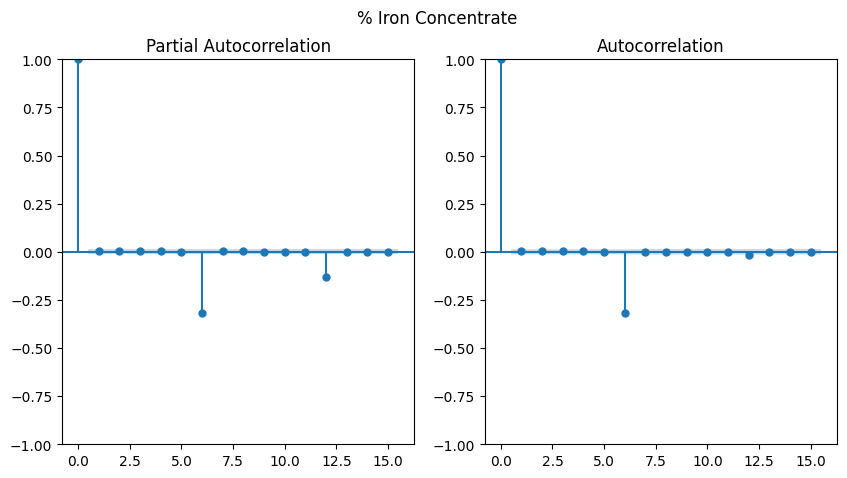

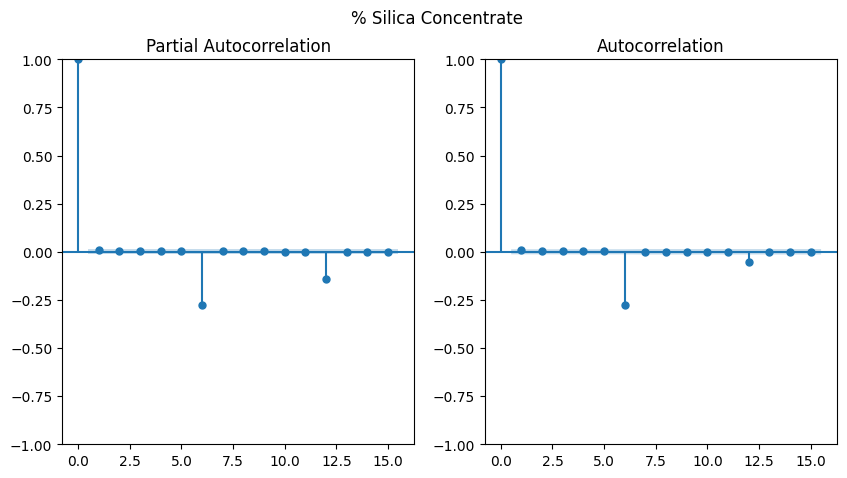

,% Iron Concentrate,% Silica Concentrate
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0


In [17]:
y = pd.DataFrame([])
for i in Y.columns :
    y[i] = Y[i] - Y[i].shift(1)
y.dropna(inplace=True)

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
for i in Y.columns :
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    fig.suptitle(i)
    plot_pacf(y[i], lags=15, ax=ax1)
    plot_acf(y[i], lags=15, ax=ax2)
    plt.show()
    
y.head()

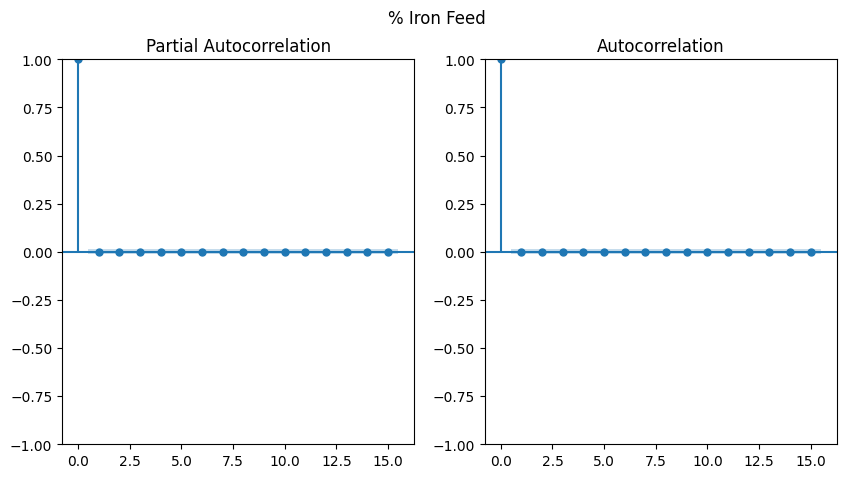

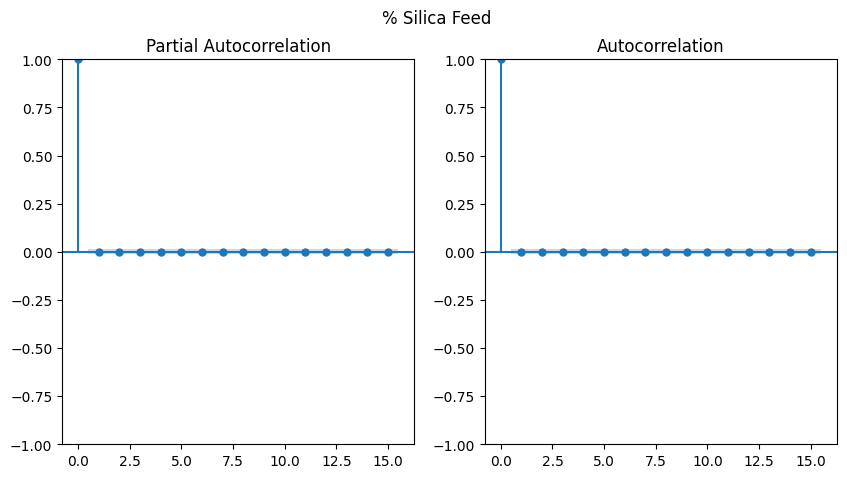

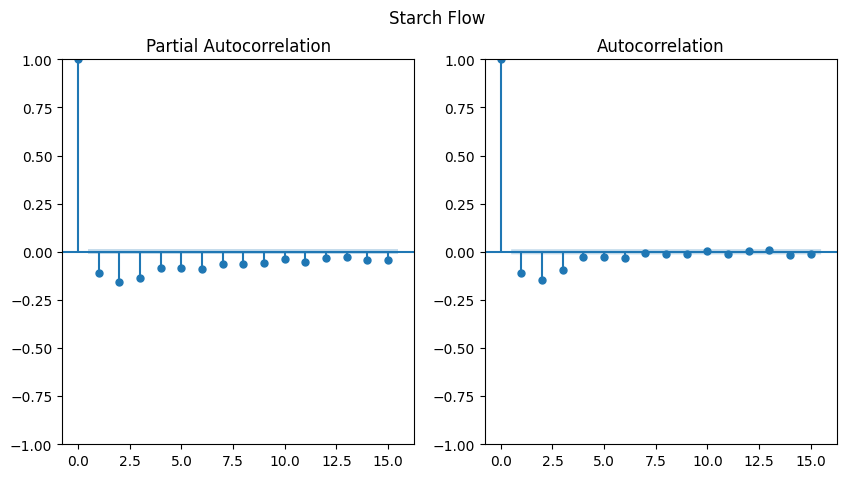

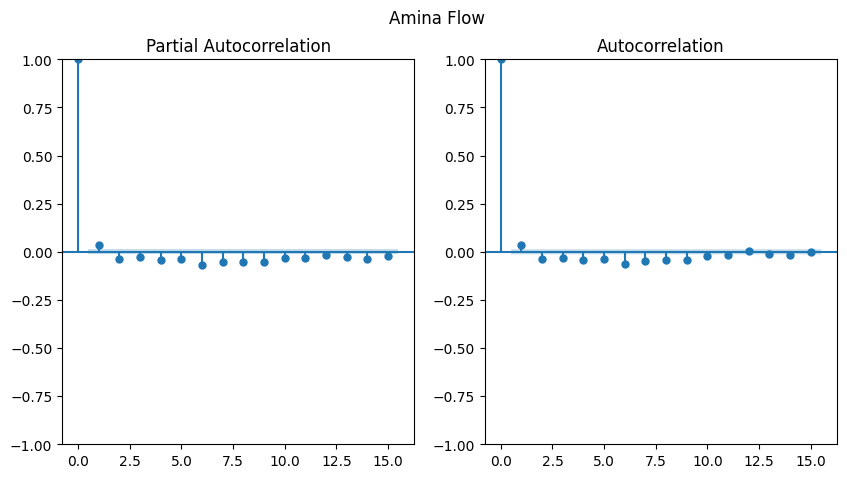

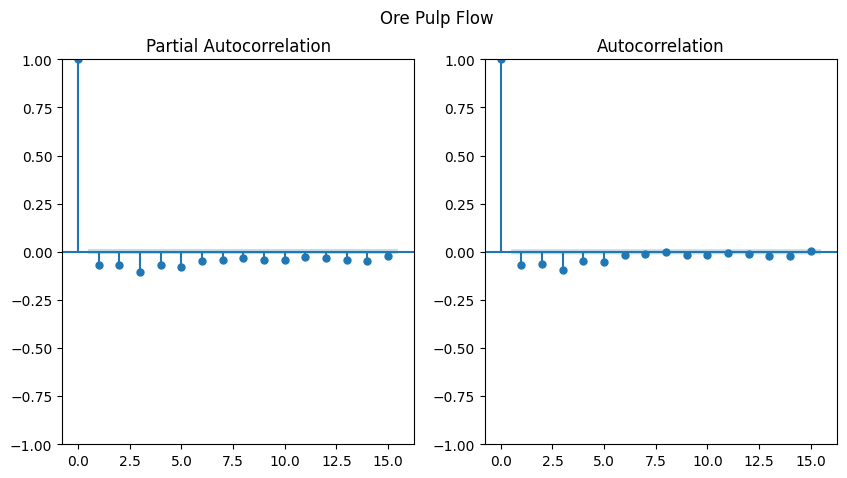

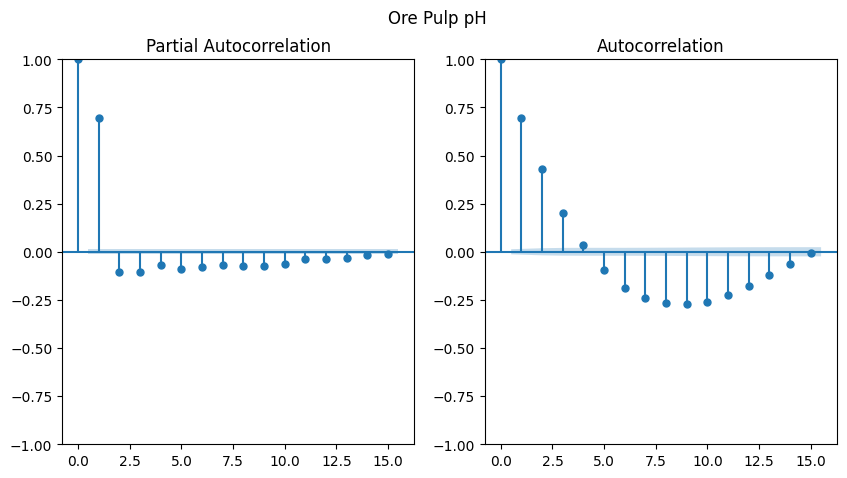

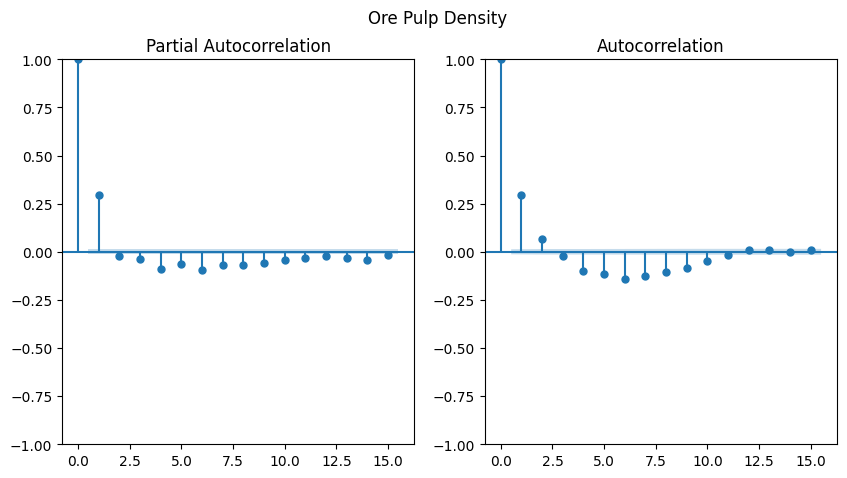

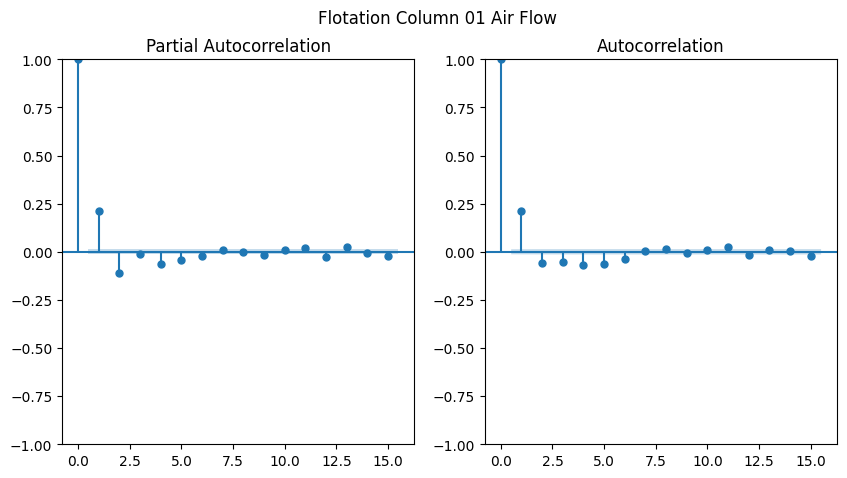

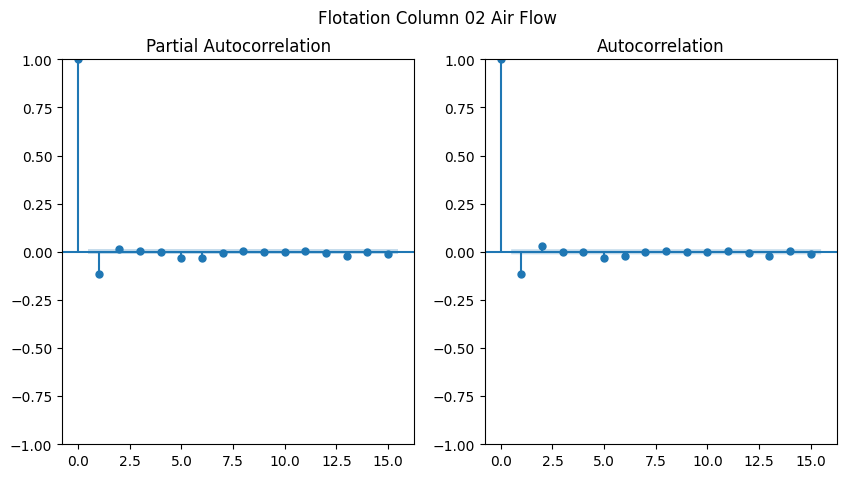

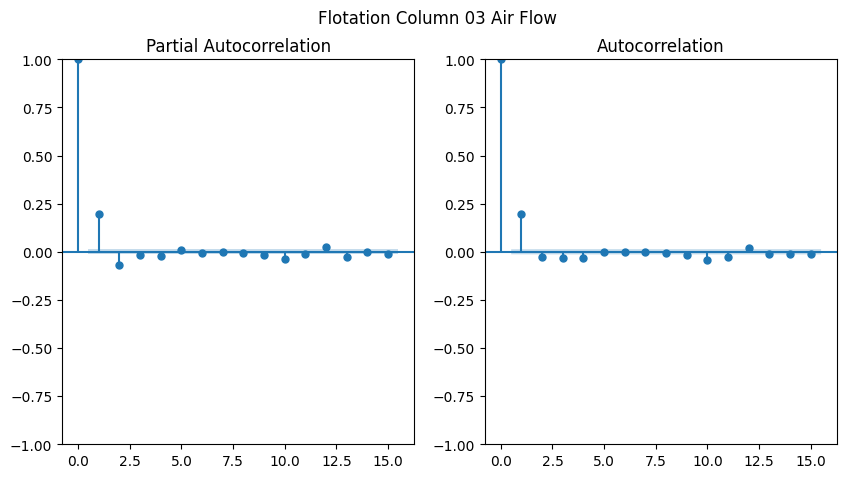

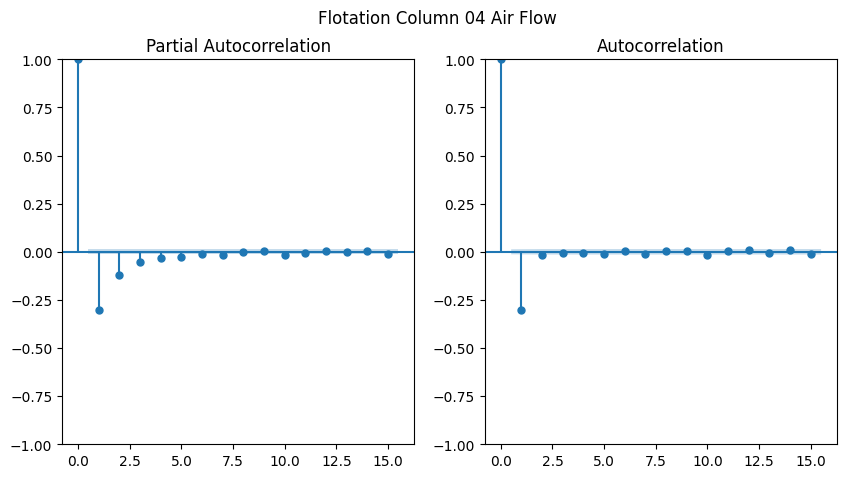

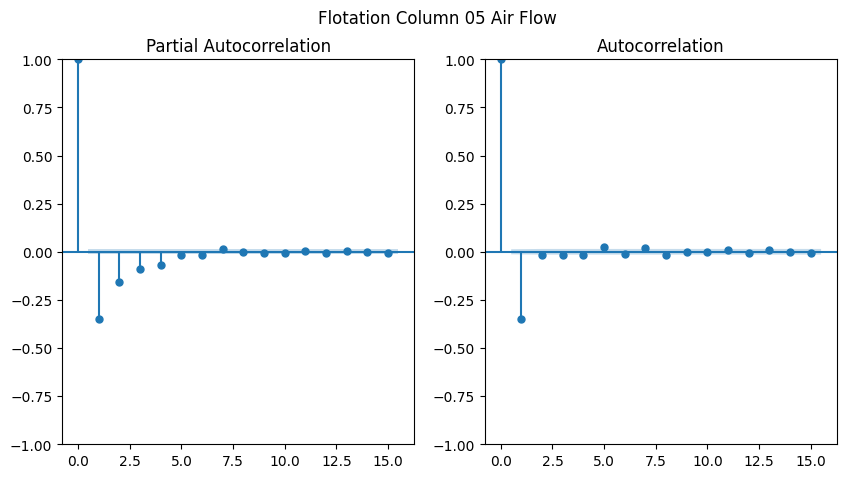

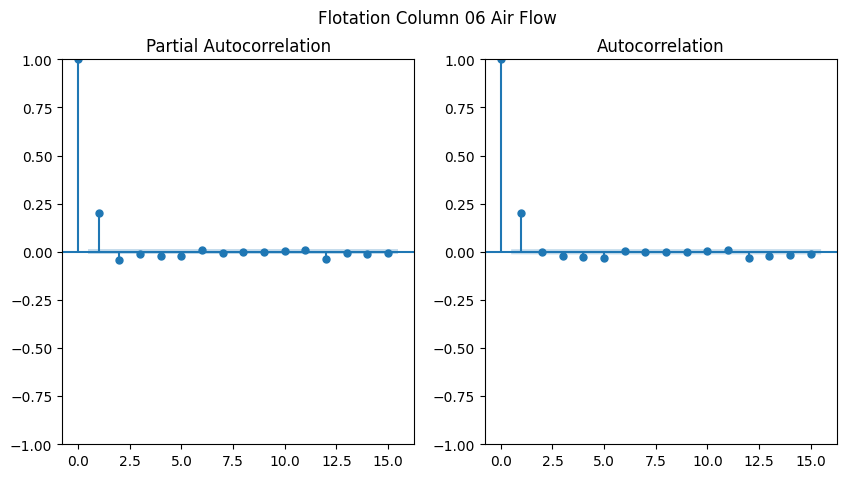

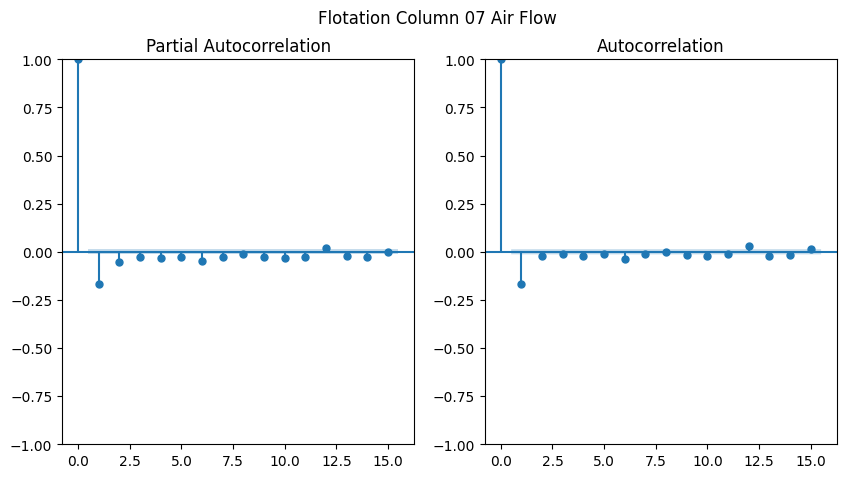

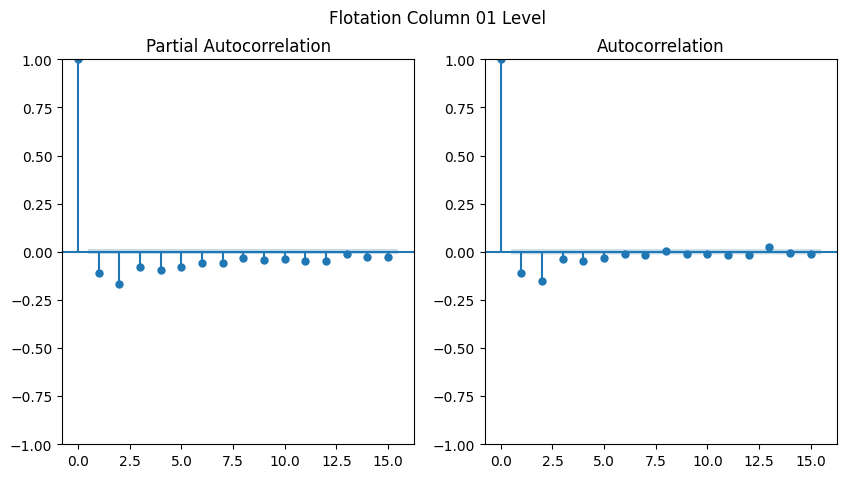

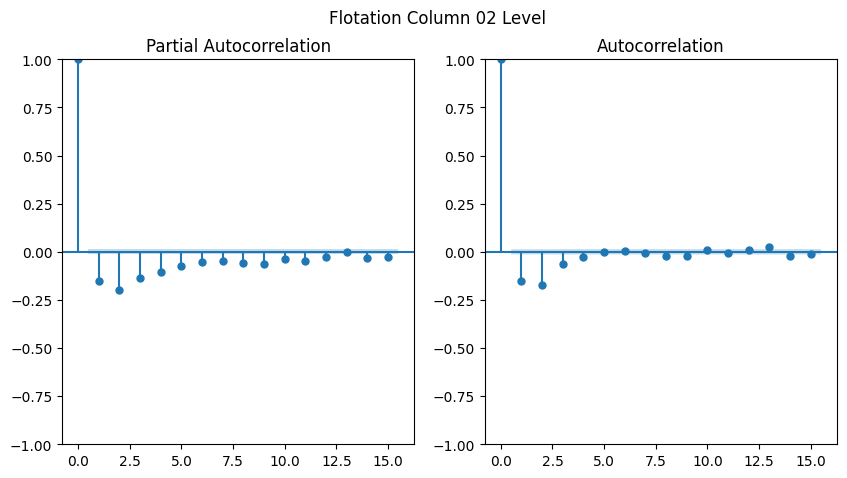

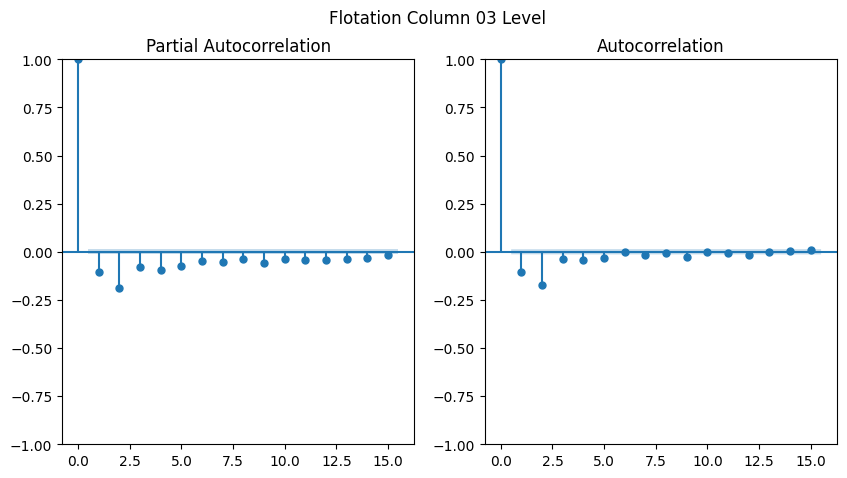

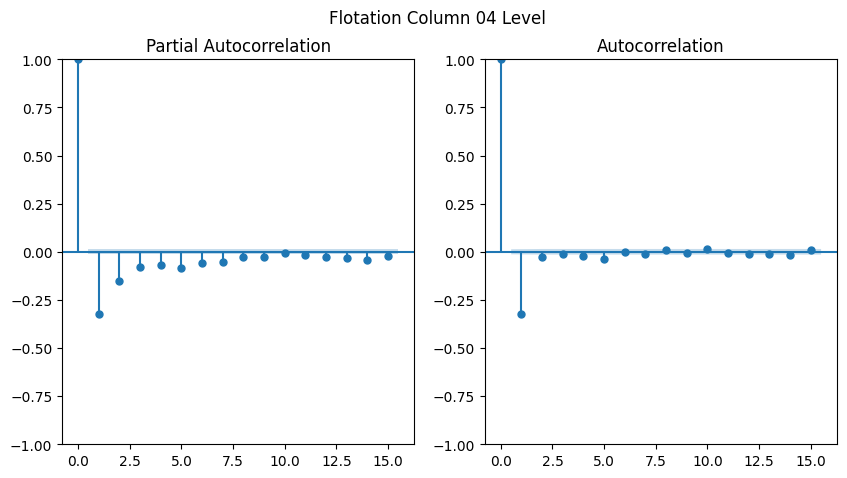

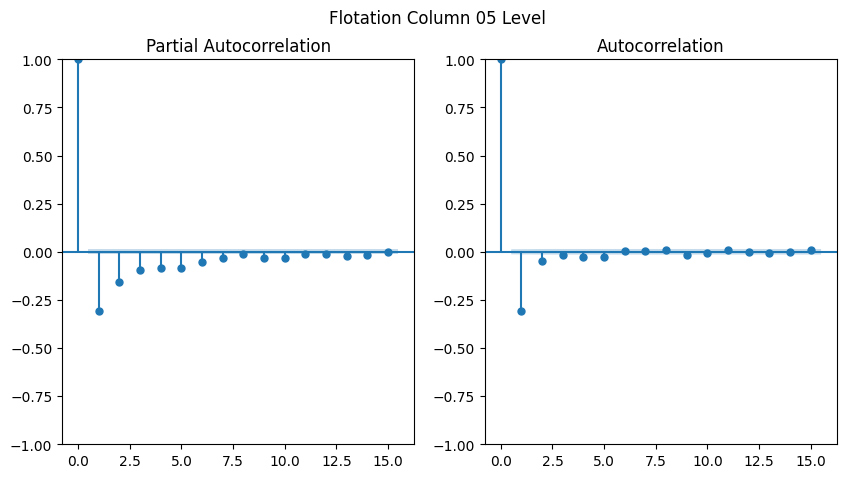

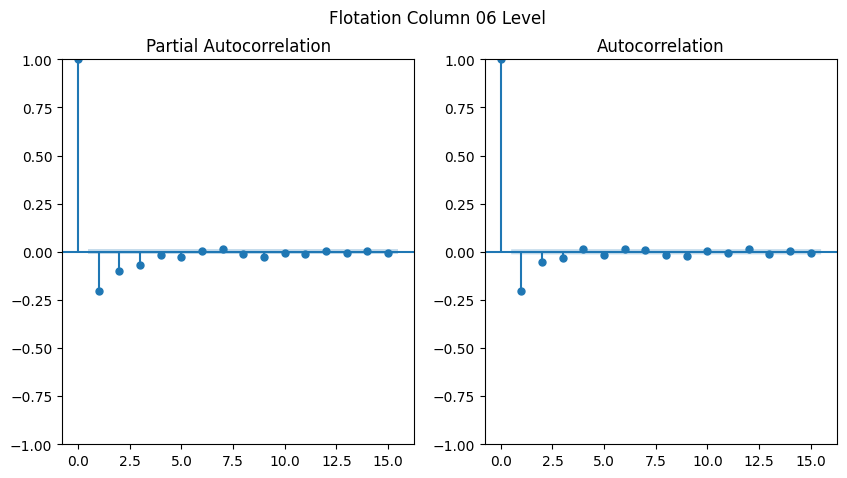

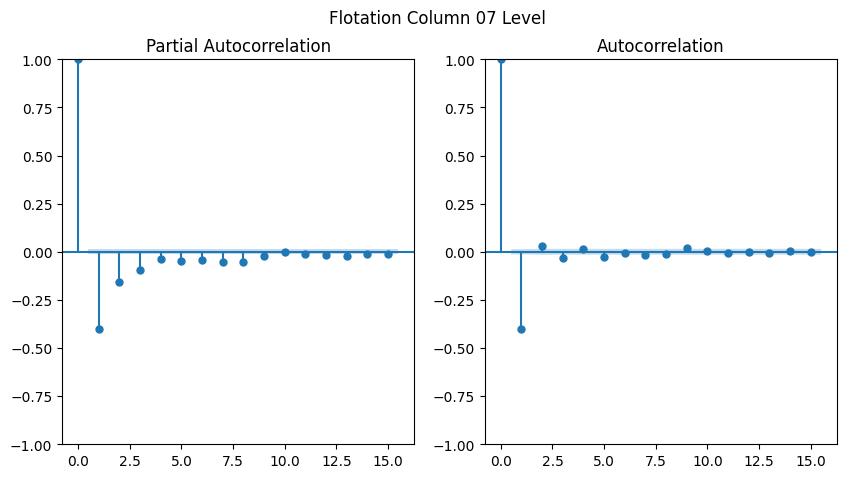

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level
1,0.0,0.0,0.054427,-0.008662,-0.073264,0.029251,0.070884,0.019129,-0.049533,0.003656,...,0.0,-0.025966,-0.024010,-0.014158,-0.009985,-0.002642,-0.076297,-0.040290,0.049052,0.027898
2,0.0,0.0,0.213566,0.075829,0.009176,0.121664,0.061058,0.015745,0.027240,0.010158,...,0.0,0.037430,0.028819,0.025136,0.010448,-0.013418,0.052947,0.027875,-0.025107,0.020328
3,0.0,0.0,-0.171611,-0.015522,-0.478608,0.112206,0.096267,-0.007456,0.017130,-0.000271,...,0.0,-0.063311,-0.008391,-0.025473,-0.016574,0.023182,-0.007400,0.011206,-0.013642,0.007945
4,0.0,0.0,-0.209238,-0.126147,0.613830,-0.032549,-0.025016,-0.000658,-0.041467,-0.009970,...,0.0,0.037384,0.032909,0.041090,0.014998,-0.007971,0.062474,0.041625,-0.048134,-0.157569
5,0.0,0.0,-0.047063,-0.105759,-0.240232,0.001085,-0.013727,-0.008822,0.042363,0.002185,...,0.0,0.050173,-0.020794,-0.017679,-0.005583,-0.005001,-0.063544,-0.054015,0.042148,0.154662


In [18]:
x = pd.DataFrame([])
for i in X.columns :
    x[i] = X[i] - X[i].shift(1)
x.dropna(inplace=True)

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
for i in X.columns :
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    fig.suptitle(i)
    plot_pacf(x[i], lags=15, ax=ax1)
    plot_acf(x[i], lags=15, ax=ax2)
    plt.show()
    
x.head()

# Predicting

In [76]:
data = pd.read_csv(path+'230609.csv', index_col=0)
data = data.drop(['time_idx', 'time_range', 'dawn', 'day', 'night'],axis=1)
data

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,hour
0,56.90,13.27,2188.172667,496.410433,400.979500,9.656423,1.748558,249.375633,250.348200,249.964633,...,699.654500,700.733367,700.101233,452.563067,451.789533,449.743700,449.483467,65.77,1.43,0
1,56.90,13.27,2246.475667,495.634233,400.291533,9.667804,1.753257,249.868133,249.040433,250.053367,...,698.061567,699.669467,699.742700,446.351400,448.587867,453.563433,451.585900,65.77,1.43,0
2,56.90,13.27,2475.248333,502.428933,400.377700,9.715140,1.757305,250.273500,249.759633,250.299933,...,700.889667,700.782800,697.921467,450.662033,450.802967,451.608367,453.117867,65.77,1.43,0
3,56.90,13.27,2291.417667,501.038067,395.883467,9.758797,1.763687,250.081533,250.211900,250.293367,...,698.023633,699.016767,701.067967,450.059533,451.693433,450.546067,453.716600,65.77,1.43,0
4,56.90,13.27,2067.281000,489.734600,401.647467,9.746133,1.762028,250.064600,249.117100,250.051367,...,702.646667,700.614833,699.986133,455.145800,455.001233,446.797833,441.841933,65.77,1.43,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21883,49.75,23.20,4067.137000,454.760300,380.728578,9.670436,1.675748,299.134467,299.967633,299.752200,...,397.769600,506.467500,863.000200,398.004533,511.730433,400.379267,398.043367,64.27,1.71,23
21884,49.75,23.20,4627.553667,452.789033,380.941306,9.684356,1.668100,299.398267,300.473267,299.590367,...,398.061067,499.167533,859.978667,400.230533,509.400967,400.798467,399.840200,64.27,1.71,23
21885,49.75,23.20,3541.358917,469.458333,380.028483,9.663314,1.664976,300.264367,300.287800,299.860400,...,400.882400,497.579433,877.082975,399.256200,487.546567,402.115133,399.659100,64.27,1.71,23
21886,49.75,23.20,3349.900667,463.325200,381.683533,9.626011,1.657615,299.975333,300.737933,300.122467,...,402.395967,493.738267,883.201692,408.094767,508.029500,403.606767,404.874067,64.27,1.71,23


In [77]:
df = data.drop(['% Iron Concentrate'],axis=1)
df

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate,hour
0,56.90,13.27,2188.172667,496.410433,400.979500,9.656423,1.748558,249.375633,250.348200,249.964633,...,250.081467,699.654500,700.733367,700.101233,452.563067,451.789533,449.743700,449.483467,1.43,0
1,56.90,13.27,2246.475667,495.634233,400.291533,9.667804,1.753257,249.868133,249.040433,250.053367,...,249.485167,698.061567,699.669467,699.742700,446.351400,448.587867,453.563433,451.585900,1.43,0
2,56.90,13.27,2475.248333,502.428933,400.377700,9.715140,1.757305,250.273500,249.759633,250.299933,...,250.200900,700.889667,700.782800,697.921467,450.662033,450.802967,451.608367,453.117867,1.43,0
3,56.90,13.27,2291.417667,501.038067,395.883467,9.758797,1.763687,250.081533,250.211900,250.293367,...,249.992500,698.023633,699.016767,701.067967,450.059533,451.693433,450.546067,453.716600,1.43,0
4,56.90,13.27,2067.281000,489.734600,401.647467,9.746133,1.762028,250.064600,249.117100,250.051367,...,250.809800,702.646667,700.614833,699.986133,455.145800,455.001233,446.797833,441.841933,1.43,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21883,49.75,23.20,4067.137000,454.760300,380.728578,9.670436,1.675748,299.134467,299.967633,299.752200,...,329.237600,397.769600,506.467500,863.000200,398.004533,511.730433,400.379267,398.043367,1.71,23
21884,49.75,23.20,4627.553667,452.789033,380.941306,9.684356,1.668100,299.398267,300.473267,299.590367,...,317.866417,398.061067,499.167533,859.978667,400.230533,509.400967,400.798467,399.840200,1.71,23
21885,49.75,23.20,3541.358917,469.458333,380.028483,9.663314,1.664976,300.264367,300.287800,299.860400,...,317.615483,400.882400,497.579433,877.082975,399.256200,487.546567,402.115133,399.659100,1.71,23
21886,49.75,23.20,3349.900667,463.325200,381.683533,9.626011,1.657615,299.975333,300.737933,300.122467,...,308.140417,402.395967,493.738267,883.201692,408.094767,508.029500,403.606767,404.874067,1.71,23


In [78]:
model = sm.tsa.VAR(data)
result = sm.tsa.VAR.select_order(model)
result.summary()

,AIC,BIC,FPE,HQIC
0,114.7,114.7,6.552e+49,114.7
1,53.32,53.54,1.439e+23,53.40
2,51.39,51.82,2.081e+22,51.53
3,51.16,51.80*,1.653e+22,51.37
4,51.07,51.92,1.516e+22,51.35
5,51.03,52.09,1.450e+22,51.37
6,50.99,52.27,1.402e+22,51.41
7,50.76,52.24,1.108e+22,51.24*
8,50.76,52.45,1.104e+22,51.31
9,50.75,52.66,1.100e+22,51.37


In [79]:
results = model.fit(3)

mae = []

for i in range(data.shape[0]-1) :
    if data['hour'][i] != data['hour'][i+1] :
        forecast = results.forecast(data.values[i-2:i+1], 6)
        for j in range(6):
            error = abs(forecast[j][-2] - data['% Silica Concentrate'][i+j])
            mae.append(error)
Mae = np.array(mae)

Mae.mean()                 
        

0.38102569338781705

In [91]:
No_Iron_model = sm.tsa.VAR(df)
result = sm.tsa.VAR.select_order(No_Iron_model)
result.summary()

,AIC,BIC,FPE,HQIC
0,115.6,115.6,1.613e+50,115.6
1,56.27,56.47,2.736e+24,56.33
2,54.33,54.73,3.954e+23,54.46
3,54.10,54.69*,3.137e+23,54.29
4,54.01,54.80,2.872e+23,54.27*
5,53.97,54.94,2.743e+23,54.29
6,53.93,55.10,2.647e+23,54.31
7,53.83,55.19,2.392e+23,54.28
8,53.83,55.38,2.378e+23,54.33
9,53.82,55.57,2.361e+23,54.39


In [92]:
No_Iron_results = No_Iron_model.fit(3)

mae = []

for i in range(df.shape[0]-1) :
    if df['hour'][i] != df['hour'][i+1] :
        No_Iron_forecast = No_Iron_results.forecast(df.values[i-2:i+1], 6)
        for j in range(6):
            error = abs(No_Iron_forecast[j][-2] - df['% Silica Concentrate'][i+j])
            mae.append(error)
Mae = np.array(mae)

Mae.mean()                 

0.3817187468341787

In [93]:
data_2 = data.iloc[:21882]
data_3 = data.iloc[21882:]

In [97]:
model_2 = sm.tsa.VAR(data_2)
result = sm.tsa.VAR.select_order(model_2)
result.summary()

,AIC,BIC,FPE,HQIC
0,114.7,114.7,6.508e+49,114.7
1,53.33,53.55,1.442e+23,53.40
2,51.39,51.82,2.085e+22,51.53
3,51.16,51.80*,1.656e+22,51.37
4,51.08,51.93,1.519e+22,51.35
5,51.03,52.09,1.453e+22,51.38
6,51.00,52.27,1.405e+22,51.41
7,50.76,52.25,1.111e+22,51.25*
8,50.76,52.45,1.107e+22,51.31
9,50.75,52.66,1.102e+22,51.38


In [98]:
results_2 = model_2.fit(3) 
forecast_2 = results_2.forecast(data_2.values[-3:], 6)

In [99]:
mae = []

for j in range(6):
    error = abs(forecast_2[j][-2] - data['% Silica Concentrate'][21882+j])
    mae.append(error)
Mae = np.array(mae)

Mae.mean()                 

0.2823899926522746

In [100]:
df_2 = df.iloc[:21882]
df_3 = df.iloc[21882:]

In [101]:
No_Iron_model_2 = sm.tsa.VAR(df_2)
No_Iron_result_2 = sm.tsa.VAR.select_order(No_Iron_model_2)
result.summary()

,AIC,BIC,FPE,HQIC
0,114.7,114.7,6.508e+49,114.7
1,53.33,53.55,1.442e+23,53.40
2,51.39,51.82,2.085e+22,51.53
3,51.16,51.80*,1.656e+22,51.37
4,51.08,51.93,1.519e+22,51.35
5,51.03,52.09,1.453e+22,51.38
6,51.00,52.27,1.405e+22,51.41
7,50.76,52.25,1.111e+22,51.25*
8,50.76,52.45,1.107e+22,51.31
9,50.75,52.66,1.102e+22,51.38


In [102]:
No_Iron_results_2 = No_Iron_model_2.fit(3) 
No_Iron_forecast_2 = No_Iron_results_2.forecast(df_2.values[-3:], 6)

In [103]:
mae = []

for j in range(6):
    error = abs(No_Iron_forecast_2[j][-2] - data['% Silica Concentrate'][21882+j])
    mae.append(error)
Mae = np.array(mae)

Mae.mean()                 

0.2542602027244311

In [189]:
data_4 = data.iloc[:16416]
data_5 = data.iloc[16416:]

In [190]:
data_4= data_4.drop(['hour'], axis =1)
data_5= data_5.drop(['hour'], axis =1)
data_6= data.drop(['hour'], axis =1)

In [195]:
data_6= data.drop(['hour'], axis =1)

In [191]:
for i in data_4.columns[:21] :
    mu, std = data_4.describe()[i][['mean','std']]
    data_4[i] = (data_4[i]-mu)/std

In [192]:
for i in data_5.columns[:21] :
    mu, std = data_5.describe()[i][['mean','std']]
    data_5[i] = (data_5[i]-mu)/std

In [193]:
model_3 = sm.tsa.VAR(data_4)
result = sm.tsa.VAR.select_order(model_3)
result.summary()

,AIC,BIC,FPE,HQIC
0,-18.34,-18.33,1.088e-08,-18.33
1,-73.58,-73.32,1.111e-32,-73.49
2,-75.54,-75.03,1.561e-33,-75.37
3,-75.81,-75.06*,1.187e-33,-75.56
4,-75.93,-74.92,1.056e-33,-75.60
5,-76.00,-74.74,9.873e-34,-75.58
6,-76.04,-74.54,9.446e-34,-75.55
7,-76.28,-74.53,7.459e-34,-75.70*
8,-76.29,-74.29,7.359e-34,-75.63
9,-76.30,-74.05,7.295e-34,-75.56


In [175]:
results_3 = model_3.fit(2) 
forecast_3 = results_3.forecast(data_4.values[-3:], 5472)

In [107]:
mae = []

for j in range(5472):
    error = abs(forecast_3[j][-2] - data['% Silica Concentrate'][16416+j])
    mae.append(error)
Mae = np.array(mae)

Mae.mean()                 

0.9428919613255236

In [181]:
df_4 = df.iloc[:16416]
df_5 = df.iloc[16416:]

In [182]:
for i in df_4.columns[:21] :
    mu, std = df_4.describe()[i][['mean','std']]
    df_4[i] = (df_4[i]-mu)/std

In [183]:
for i in df_5.columns[:21] :
    mu, std = df_5.describe()[i][['mean','std']]
    df_5[i] = (df_5[i]-mu)/std

In [184]:
No_Iron_model_3 = sm.tsa.VAR(df_4)
No_Iron_result_3 = sm.tsa.VAR.select_order(No_Iron_model_3)
result.summary()

,AIC,BIC,FPE,HQIC
0,109.4,109.4,3.247e+47,109.4
1,51.63,51.91,2.635e+22,51.72
2,49.67,50.22*,3.714e+21,49.85
3,49.40,50.22,2.834e+21,49.67
4,49.28,50.38,2.529e+21,49.64
5,49.22,50.59,2.375e+21,49.67
6,49.18,50.82,2.280e+21,49.72
7,48.93,50.84,1.776e+21,49.56*
8,48.92,51.10,1.759e+21,49.64
9,48.91,51.36,1.748e+21,49.72


In [169]:
No_Iron_results_3 = No_Iron_model_3.fit(2) 
No_Iron_forecast_3 = No_Iron_results_3.forecast(df_4.values[-3:], 5472)

In [115]:
mae = []

for j in range(5472):
    error = abs(No_Iron_forecast_3[j][-2] - df['% Silica Concentrate'][16416+j])
    mae.append(error)
Mae = np.array(mae)

Mae.mean()                 

0.9429464689990703

In [196]:
results_3 = model_3.fit(2)

mae = []

for i in range(5466) :
    forecast = results_3.forecast(data_6.values[16414+i:16417+i], 6)
    for j in range(6):
        error = abs(forecast[j][-2] - data['% Silica Concentrate'][16417+i+j])
        mae.append(error)
Mae = np.array(mae)

Mae.mean()                 
        

38.10286876352993

In [185]:
No_Iron_result_3 = No_Iron_model_3.fit(2)

mae = []

for i in range(5466) :
    forecast = No_Iron_result_3.forecast(df.values[16414+i:16417+i], 6)
    for j in range(6):
        error = abs(forecast[j][-2] - data['% Silica Concentrate'][16417+i+j])
        mae.append(error)
Mae = np.array(mae)

Mae.mean()                 
        

25.399381464854926